In [16]:
import pandas as pd
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Food_Reviews.csv')

Dataset diambil di Google Drive, sebelumnya di download di https://www.kaggle.com/anjaliagrawal12/food-review

In [17]:
df.head()

,Text,Score
0,I have bought several of the Vitality canned d...,3
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,3
3,If you are looking for the secret ingredient i...,1
4,Great taffy at a great price. There was a wid...,3


Informasi Dataset, yaitu terdiri dari 2 Kolom dan sebanyak 9998 baris/sampel data

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    9999 non-null   object
 1   Score   9999 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


Melakukan proses one-hot-encoding, karena data kategorikal

In [19]:
category = pd.get_dummies(df.Score)
df_baru = pd.concat([df, category], axis=1)
df_baru = df_baru.drop(columns='Score')
df_baru

,Text,1,2,3
0,I have bought several of the Vitality canned d...,0,0,1
1,Product arrived labeled as Jumbo Salted Peanut...,1,0,0
2,This is a confection that has been around a fe...,0,0,1
3,If you are looking for the secret ingredient i...,1,0,0
4,Great taffy at a great price. There was a wid...,0,0,1
...,...,...,...,...
9994,Their Earl Grey and English breakfast do not c...,1,0,0
9995,My daughter loves this tea and so I purchased ...,0,1,0
9996,I honestly don't know how this item is allowed...,1,0,0
9997,"Enjoy the taste of the tea, however I think it...",0,1,0


Mengubah nilai-nilai dari dataframe ke dalam tipe data numpy array menggunakan atribut values

In [20]:
reviews = df_baru['Text'].values
score = df_baru[[1, 2, 3]].values

In [21]:
score

array([[0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       ...,
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]], dtype=uint8)

Membagi data untuk training dan data untuk testing, dimana validasi set 20%

In [22]:
from sklearn.model_selection import train_test_split
reviews_latih, reviews_test, score_latih, score_test = train_test_split(reviews, score , test_size=0.2)

Merubah setiap kata pada dataset ke dalam bilangan numerik dengan fungsi Tokenizer. Setelah tokenisasi selesai, perlu membuat mengonversi setiap sampel menjadi sequence.

In [23]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
 
tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(reviews_latih) 
tokenizer.fit_on_texts(reviews_test)
 
sekuens_latih = tokenizer.texts_to_sequences(reviews_latih)
sekuens_test = tokenizer.texts_to_sequences(reviews_test)
 
padded_latih = pad_sequences(sekuens_latih) 
padded_test = pad_sequences(sekuens_test)

Model aksitektur menggunakan Layer Embedding, fungsi compile, menentukan optimizer dan menggunakan model loss function dimana model lebih dari 2

In [24]:
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=16),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

Penggunaan fungsi callback, untuk membantu model jika sudah mencapai target >90%

In [25]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9):
      print("\nAkurasi telah mencapai >90%!")
      self.model.stop_training = True
callbacks = myCallback()

In [26]:
num_epochs = 23
history = model.fit(padded_latih, score_latih, epochs=num_epochs, callbacks=[callbacks],
                    validation_data=(padded_test, score_test), verbose=2)

Epoch 1/23
250/250 - 328s - loss: 0.6262 - accuracy: 0.7777 - val_loss: 0.5282 - val_accuracy: 0.7940
Epoch 2/23
250/250 - 310s - loss: 0.4521 - accuracy: 0.8312 - val_loss: 0.5066 - val_accuracy: 0.8110
Epoch 3/23
250/250 - 307s - loss: 0.3581 - accuracy: 0.8602 - val_loss: 0.5082 - val_accuracy: 0.8195
Epoch 4/23
250/250 - 307s - loss: 0.3143 - accuracy: 0.8779 - val_loss: 0.5207 - val_accuracy: 0.8235
Epoch 5/23
250/250 - 306s - loss: 0.2671 - accuracy: 0.8906 - val_loss: 0.6079 - val_accuracy: 0.8125
Epoch 6/23

Akurasi telah mencapai >90%!
250/250 - 305s - loss: 0.2218 - accuracy: 0.9122 - val_loss: 0.7202 - val_accuracy: 0.8030


Plot Loss dan Akurasi pada saat  training dan validasi

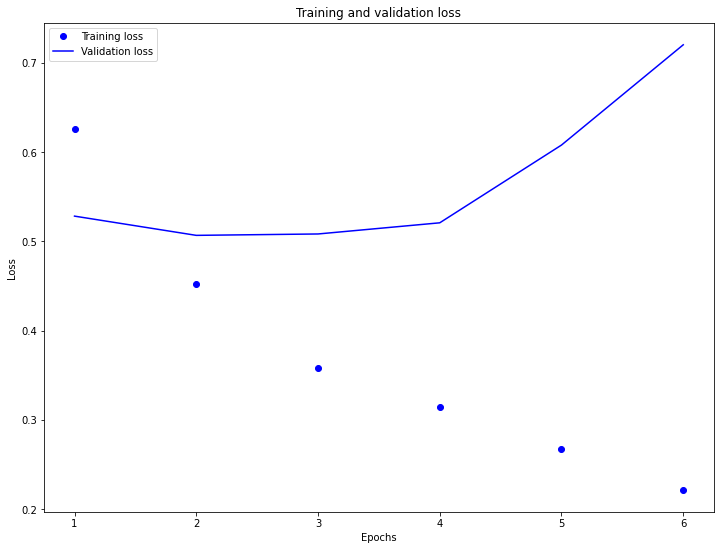

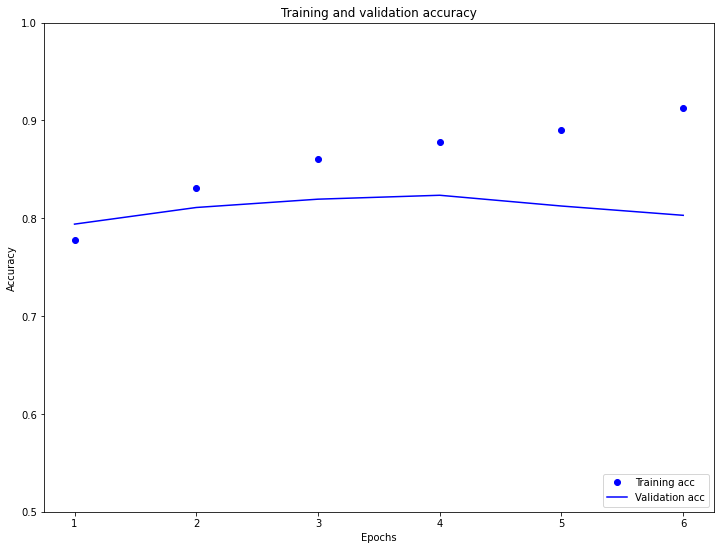

In [27]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()